In [1]:
import matplotlib.pyplot as plt
%matplotlib widget

import numpy as np
import h5py
import colorsys

from utils.decompose_dict_and_h5_groups import decompose_h5_groups_to_dict
from analysis.utils.extract_from_metadata_file import extract_from_metadata_file
from utils.imaging_utils import load_config
from utils.load_rois_data import load_rois_data

from utils.paint_roi import paint_roi
from analysis.plots import *

from analysis.utils.peristimulus_time_response import calc_pstr


In [2]:
# mouse ID, sessions to examine and all other parameters - CHANGE IT IF NECESSARY
mouse_id = '2680'

sessions_names = [
#     '20220221_neurofeedback',
#     '20220222_neurofeedback',
    '20220223_neurofeedback',
    '20220224_neurofeedback',
    '20220227_neurofeedback',
    '20220228_neurofeedback'
]

In [3]:

# data paths
base_path = '/data/Rotem/WideFlow prj'
dataset_path = f'{base_path}/results/sessions_20220220.h5'

# Allen cortex
# cortex_map_path = '/data/Rotem/Wide Field/WideFlow/data/cortex_map/allen_2d_cortex.h5'
# rois_dict_path = '/data/Rotem/Wide Field/WideFlow/data/cortex_map/allen_2d_cortex_rois.h5'  # whole cortex
# rois_dict_path = '/data/Rotem/Wide Field/WideFlow/data/cortex_map/allen_2d_cortex_rois.h5'  # cortex left hemisphere

# functional parcellation
cortex_map_path = f'{base_path}/{mouse_id}/functional_parcellation_cortex_map.h5'
rois_dict_path = f'{base_path}/{mouse_id}/functional_parcellation_rois_dict_left_hemi.h5'  # left hemisphere


In [4]:
# load supplementary data
with h5py.File(cortex_map_path, 'r') as f:
    cortex_mask = np.transpose(f["mask"][()])
    cortex_map = np.transpose(f["map"][()])

rois_dict = load_rois_data(rois_dict_path)
rois_names_code = list(rois_dict.keys())
rois_names = [v['name'] for k, v in rois_dict.items()]
nrois = len(rois_dict)

# load sessions results summary
sessions_data = {}
with h5py.File(dataset_path, 'a') as f:
    decompose_h5_groups_to_dict(f, sessions_data, f'/{mouse_id}/')

# load sessions metadata
sessions_metadata = {}
for sess_name in sessions_names:
    sess_metadata_path = f'{base_path}/{mouse_id}/{sess_name}/metadata.txt'
    timestamp, cue, metric_result, threshold, serial_readout = extract_from_metadata_file(sess_metadata_path)
    sessions_metadata[sess_name] = {"timestamp": timestamp, "cue": cue, "metric_result": metric_result, "threshold": threshold, "serial_readout": serial_readout}

# load sessions config
sessions_config = {}
for sess_name in sessions_names:
    sess_config_path = f'{base_path}/{mouse_id}/{sess_name}/session_config.json'
    config = load_config(sess_config_path)
    sessions_config[sess_name] = config


In [5]:
# prepare results
for sess_name in sessions_names:
    metric_roi = sessions_config[sess_name]['analysis_pipeline_config']['args']['metric_args'][1][0]
    metric_bool_arr = [True if metric_roi==key else False for key in rois_dict.keys()]
    non_metric_bool_arr = np.invert(metric_bool_arr)
    sessions_metadata[sess_name]['metric_roi'] = metric_roi
    sessions_metadata[sess_name]['metric_bool_arr'] = metric_bool_arr
    sessions_metadata[sess_name]['non_metric_bool_arr'] = non_metric_bool_arr
    

/data/Rotem/Wide Field/WideFlow/wideflow/analysis/plots.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.int32(np.linspace(0, t[-1], 10)))


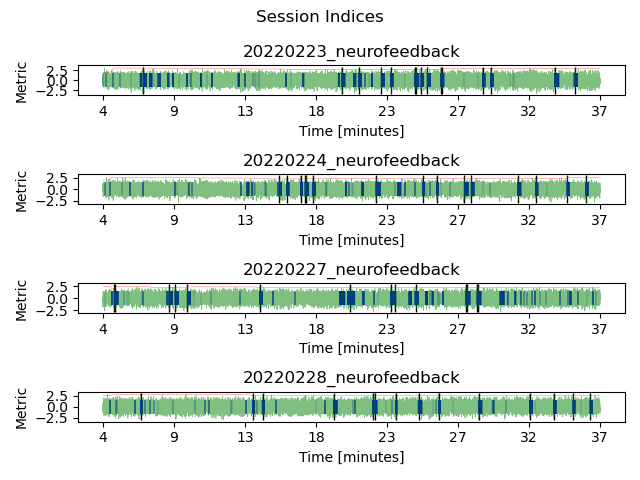

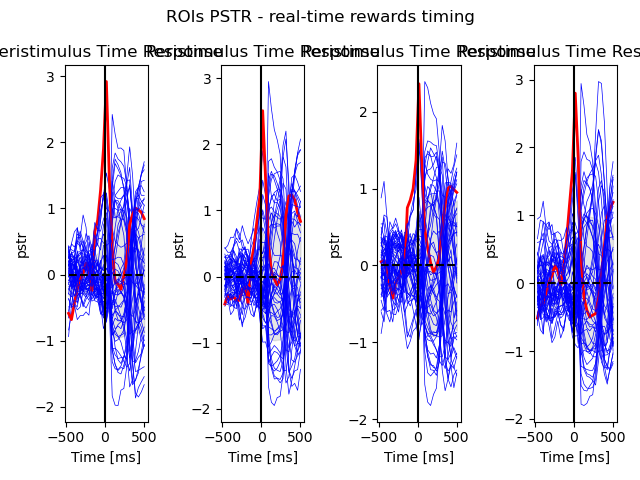

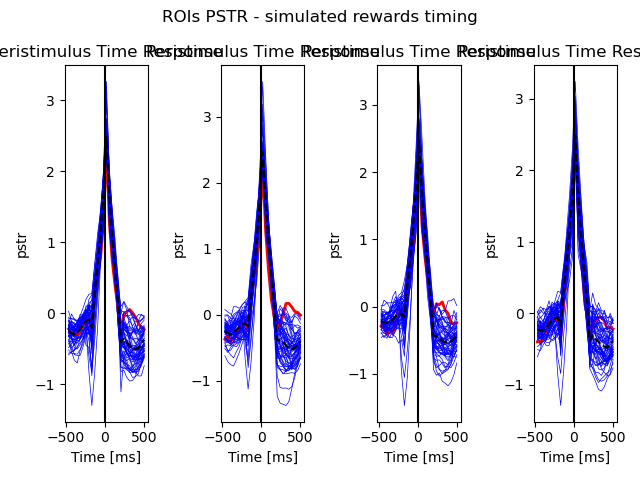

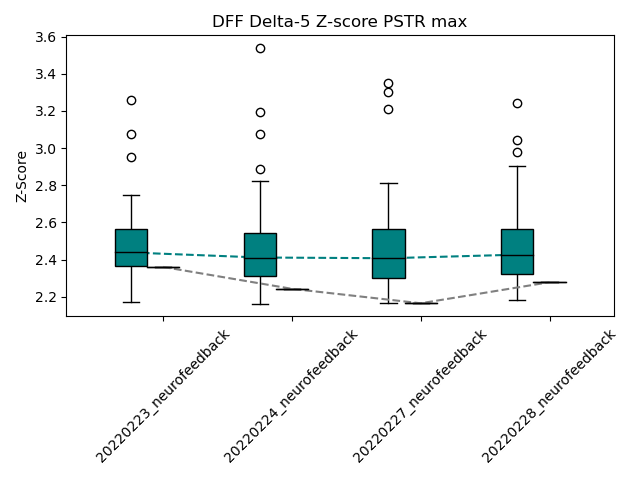

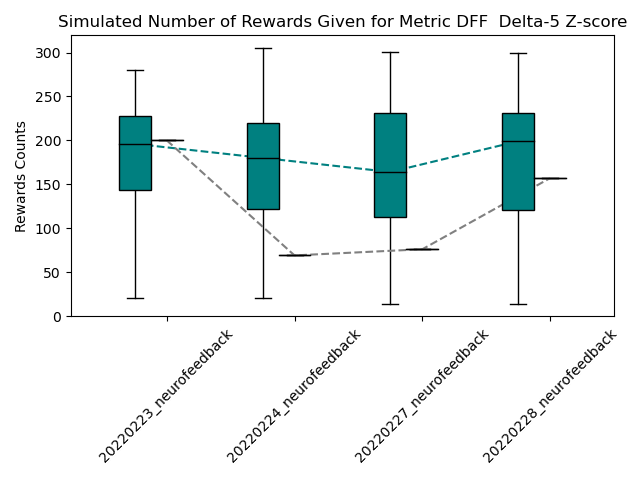

In [6]:
# evaluate learning
# plot sessions indices
f, axes = plt.subplots(len(sessions_names), 1)
if not isinstance(axes, np.ndarray):
    axes = [axes]
for i, sess_name in enumerate(sessions_names):
    dt = np.mean(np.diff(sessions_metadata[sess_name]["timestamp"]))
    plot_session(axes[i], 
                  sessions_metadata[sess_name]["metric_result"], 
                  sessions_metadata[sess_name]["cue"],
                  sessions_metadata[sess_name]["serial_readout"],
                  sessions_metadata[sess_name]["threshold"], 
                  dt)
    axes[i].set_title(sess_name)
f.suptitle("Session Indices")
plt.tight_layout()


# plot sessions pstr according to real-time rewards timing
f, axes = plt.subplots(1, len(sessions_names))
if not isinstance(axes, np.ndarray):
    axes = [axes]
for i, sess_name in enumerate(sessions_names):
    rois_pstr_dict = {}
    for j, roi_key in enumerate(rois_dict.keys()):
        rois_pstr_dict[roi_key] = sessions_data[sess_name]['post_session_analysis']['dff_delta5']['zscore_pstr'][j]
    
    dt = np.mean(np.diff(sessions_metadata[sess_name]['timestamp']))
    plot_pstr(axes[i], rois_pstr_dict, dt, bold_list=metric_roi)

f.suptitle("ROIs PSTR - real-time rewards timing") 
plt.tight_layout()


# plot sessions pstr according to simulated rewards timing, for a fixed threshold
f, axes = plt.subplots(1, len(sessions_names))
if not isinstance(axes, np.ndarray):
    axes = [axes]
for i, sess_name in enumerate(sessions_names):
    rois_pstr_dict = {}
    for j, roi_key in enumerate(rois_dict.keys()):
        rois_pstr_dict[roi_key] = sessions_data[sess_name]['post_session_analysis']['dff_delta5']['zscore_pstr_sim_reward'][j]
    
    dt = np.mean(np.diff(sessions_metadata[sess_name]['timestamp']))
    plot_pstr(axes[i], rois_pstr_dict, dt, bold_list=metric_roi)

f.suptitle("ROIs PSTR - simulated rewards timing") 
plt.tight_layout()


# plot sessions pstr maximum value box-plot according to simulated rewards timing, for a fixed threshold
pstr_zscore_max_nm, pstr_zscore_max_m = [], []
for i, sess_name in enumerate(sessions_names):
    pstr_zscore_max_m.append([])
    pstr_zscore_max_nm.append([])
    for j, roi_key in enumerate(rois_dict.keys()):
        if roi_key == sessions_metadata[sess_name]['metric_roi']:
            pstr_zscore_max_m[i].append(np.max(sessions_data[sess_name]['post_session_analysis']['dff_delta5']['zscore_pstr_sim_reward'][j]))
        else:
            pstr_zscore_max_nm[i].append(np.max(sessions_data[sess_name]['post_session_analysis']['dff_delta5']['zscore_pstr_sim_reward'][j]))
        
pstr_zscore_max_m = np.transpose(np.array(pstr_zscore_max_m))
pstr_zscore_max_nm = np.transpose(np.array(pstr_zscore_max_nm))


f, ax = plt.subplots()        
plot_box_plot(ax, pstr_zscore_max_nm, pstr_zscore_max_m, 
              set_title="DFF Delta-5 Z-score PSTR max",
              set_xticklabels={'labels':sessions_names, 'rotation':45},
              set_ylabel = 'Z-Score')
plt.tight_layout()


# plot sessions number of rewards box-plot according to simulated rewards timing, for a fixed threshold
num_of_rewards_nm, num_of_rewards_m = [], []
for i, sess_name in enumerate(sessions_names):
    num_of_rewards_m.append([])
    num_of_rewards_nm.append([])
    for roi_key, roi_val in sessions_data[sess_name]['post_session_analysis']['dff_delta5']['traces_zscore_sim_reward_timing'].items():
        if roi_key == sessions_metadata[sess_name]['metric_roi']:
            num_of_rewards_m[i].append(len(roi_val))
        else:
            num_of_rewards_nm[i].append(len(roi_val))
        
num_of_rewards_m = np.transpose(np.array(num_of_rewards_m))
num_of_rewards_nm = np.transpose(np.array(num_of_rewards_nm))

f, ax = plt.subplots()        
plot_box_plot(ax, num_of_rewards_nm, num_of_rewards_m, 
              set_title="Simulated Number of Rewards Given for Metric DFF  Delta-5 Z-score",
              set_xticklabels={'labels':sessions_names, 'rotation':45},
              set_ylabel='Rewards Counts')
plt.tight_layout()


# plot sessions box-plot according to Z-score AUC
zscore_auc_nm, zscore_auc_m = [], []
for i, sess_name in enumerate(sessions_names):
    zscore_auc_m.append([])
    zscore_auc_nm.append([])
    for j, roi_key in enumerate(rois_dict.items()):
        
        if roi_key == sessions_metadata[sess_name]['metric_roi']:
            zscore_auc_m[i].append(sessions_data[sess_name]['post_session_analysis']['dff_delta5']['zscore_auc'][j])
        else:
            zscore_auc_nm[i].append(sessions_data[sess_name]['post_session_analysis']['dff_delta5']['zscore_auc'][j])
        
zscore_auc_m = np.transpose(np.array(num_of_rewards_m))
zscore_auc_nm = np.transpose(np.array(num_of_rewards_nm))

f, ax = plt.subplots()        
plot_box_plot(ax, zscore_auc_nm, zscore_auc_m, 
              set_title="Z-score AUC",
              set_xticklabels={'labels':sessions_names, 'rotation':45},
              set_ylabel='auc')
plt.tight_layout()